In [61]:
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm_notebook as tqdm
import pickle
import os
from typing import List, Dict
import seaborn as sns
sns.set_palette("dark")

In [65]:
os.chdir("../../java")

FileNotFoundError: [Errno 2] No such file or directory: '../../java'

In [62]:
colormap = {
    "cooperative": "C0",
    "truncation": "C1",
    "pps": "C2",
    "random_sample": "C3",
    "dyadic_truncation": "C6",
    
    "dyadic_b4": "C1",
    "dyadic_b10": "C2",

    "q_cooperative": "C0",
    "q_truncation": "C1",
    "q_pps": "C2",
    "q_random_sample": "C3",
    "q_dyadic_b2": "C6",
    
    "spacesaving": "C4",
    "cms_min": "C5",
    "kll": "C4",
    "yahoo_mg": "C7",
}
markers = {
    "cooperative": "x",
    "truncation": "^",
    "pps": "s",
    "random_sample": "+",
    
    "dyadic_truncation": "<",
    "dyadic_b4": "^",
    "dyadic_b10": "+",

    "q_cooperative": "x",
    "q_truncation": "^",
    "q_pps": "s",
    "q_random_sample": "+",
    "q_dyadic_b2": "<",

    "spacesaving": "D",
    "cms_min": "o",
    "kll": "D",
    "yahoo_mg": "*",
}
alg_display_name = {
    "cooperative": "Cooperative",
    "truncation": "Truncation",
    "pps": "PPS",
    "random_sample": "USample",
    
    "dyadic_truncation": "Hierarchy",
    "dyadic_b4": "Hierarchy $b=4$",
    "dyadic_b10": "Hierarchy $b=10$",

    "q_cooperative": "Cooperative",
    "q_truncation": "Truncation",
    "q_pps": "PPS",
    "q_random_sample": "USample",
    "q_dyadic_b2": "Hierachy",

    "spacesaving": "SpaceSaving",
    "cms_min": "CMS",
    "kll": "KLL",
    "yahoo_mg": "MG"
}
data_display_name = {
    "caida_10M": "CAIDA",
    "zipf1p1_10M": "Zipf",
    "msft_network_10M": "Provider",
    "msft_os_10M": "OSBuild",
    "power_2M": "Power",
    "uniform_1M": "Uniform",
    "msft_records_10M": "Traffic",
}

In [63]:
def get_error_file(experiment_name):
    return os.path.join(
        "output/results/{}".format(experiment_name),
        "errors.csv"
    )

In [66]:
def query_length_plot(
    experiment_name,
    sketch_names: List,
    item_agg="max",
    query_agg="mean",
    ax = None,
    absolute=False,
):
    e_combined = pd.read_csv(get_error_file(experiment_name))
    e_combined["e_norm"] = e_combined[item_agg] / e_combined["total"]
    if absolute:
        e_combined["e_norm"] = e_combined[item_agg]
    eg = e_combined.groupby(["sketch", "query_len"]).aggregate({
        "e_norm": ["mean", "std", "max", "count"],
    })
    eg["err"] = eg[("e_norm", query_agg)]
    eg["err_std"] = eg["e_norm", "std"] / np.sqrt(eg["e_norm", "count"])
    if ax is None:
        f = plt.figure(figsize=(6,4.5))
        ax = f.gca()
    for method in sketch_names:
        eg_cur = eg.loc[method]

        ax.errorbar(
            eg_cur.index,
            eg_cur["err"],
            yerr=eg_cur["err_std"],
            color=colormap[method],
            markersize=5,
            lw=.5,
        )
        ax.plot(
            eg_cur.index,
            eg_cur["err"],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
            fillstyle="none",
            lw=.5,
        )

        ax.set_xscale("log")
        ax.set_yscale("log")
#         ax.grid(axis="y", linestyle=(0, (2, 10)))
    return ax, eg

In [67]:
def query_time_plot(
    experiment_name,
    sketch_names: List,
    ax = None,
):
    e_combined = pd.read_csv(get_error_file(experiment_name))
    eg = e_combined.groupby(["sketch", "query_len"]).aggregate({
        "query_time": ["mean", "std", "max", "count"],
    })
    eg["time"] = eg[("query_time", "mean")]
    for method in sketch_names:
        eg_cur = eg.loc[method]

        ax.plot(
            eg_cur.index,
            eg_cur["time"],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
            fillstyle="none",
            lw=.5,
        )

        ax.set_xscale("log")
        ax.set_yscale("log")
#         ax.grid(axis="y", linestyle=(0, (2, 10)))
    return ax, eg

/Users/edgan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/edgan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


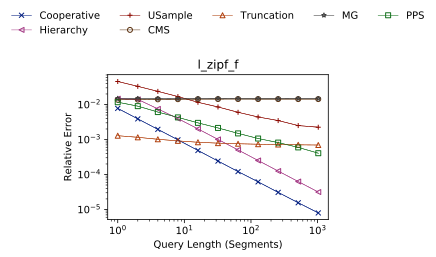

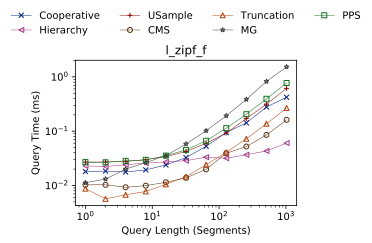

In [8]:
sketch_names = [
    "cooperative", 
    "dyadic_truncation", 
    "random_sample", 
    "cms_min", 
    "truncation", 
    "yahoo_mg",
    "pps"
]
sketch_size = 64
experiments = [
    "l_zipf_f",
    "l_caida_f",
    "l_mos_f",
    "l_mnetwork_f",
]
cur_experiment = experiments[0]

fig = plt.figure(figsize=(4,3), dpi=100)
ax = fig.gca()

query_length_plot(
    cur_experiment,
    sketch_names,
    item_agg="max",
    query_agg="mean",
    ax=ax,
    absolute=False,
)
ax.set_title(cur_experiment)
ax.set_xlabel("Query Length (Segments)")
ax.set_ylabel("Relative Error")

fig.tight_layout()
lgd = ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(.5, 1.5), ncol=5)
fig.show()
# fname = "output/plots/linear_freq.pdf"
# fname = "output/{}/query_error.png".format(cur_experiment)
# fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

fig = plt.figure(figsize=(4,3), dpi=100)
ax = fig.gca()

query_time_plot(
    cur_experiment,
    sketch_names,
    ax=ax,
)
ax.set_title(cur_experiment)
ax.set_xlabel("Query Length (Segments)")
ax.set_ylabel("Query Time (ms)")

fig.tight_layout()
lgd = ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(.5, 1.4), ncol=4)
fig.show()
# fname = "output/{}/query_time.png".format(cur_experiment)
# fig.savefig(fname, dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')

/Users/edgan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/edgan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


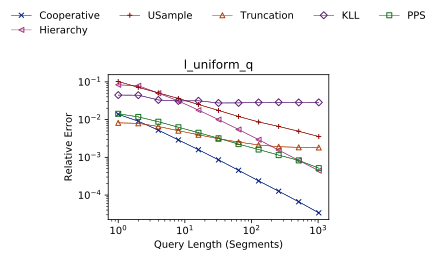

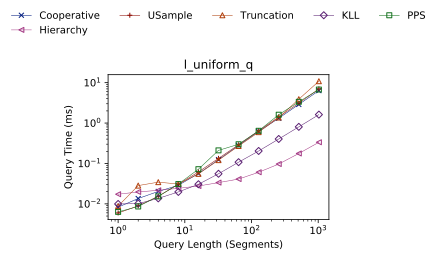

In [79]:
sketch_names = [
    "cooperative", 
    "dyadic_truncation", 
#     "dyadic_b3",
    "random_sample", 
    "truncation", 
    "kll",
    "pps"
]
sketch_size = 64
experiments = [
    "l_power_q",
    "l_mrecords_q",
    "l_uniform_q",
]
cur_experiment = experiments[2]

fig = plt.figure(figsize=(4,3), dpi=100)
ax = fig.gca()

query_length_plot(
    cur_experiment,
    sketch_names,
    item_agg="max",
    query_agg="mean",
    ax=ax,
    absolute=False,
)
ax.set_title(cur_experiment)

ax.set_xlabel("Query Length (Segments)")
ax.set_ylabel("Relative Error")


fig.tight_layout()
lgd = ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(.5, 1.5), ncol=5)
fig.show()
# fname = "output/plots/linear_freq.pdf"
# fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

fig = plt.figure(figsize=(4,3), dpi=100)
ax = fig.gca()

query_time_plot(
    cur_experiment,
    sketch_names,
    ax=ax,
)
ax.set_title(cur_experiment)
ax.set_xlabel("Query Length (Segments)")
ax.set_ylabel("Query Time (ms)")

fig.tight_layout()
lgd = ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(.5, 1.5), ncol=5)
fig.show()

# Cubes

In [53]:
df = pd.read_csv(get_error_file("c_bcube_f"))
df["err_n"] = df["max"] / df["total"]
dfg = df.groupby(["sketch"]).aggregate({"err_n": "mean"})

In [54]:
dfg

,err_n
sketch,
cms_min,0.077907
pps,0.003118
pps_coop,0.001655
random_sample,0.007151
random_sample_prop,0.005885
random_sample_strat,0.004907
truncation,0.003062
yahoo_mg,0.029557


In [59]:
df = pd.read_csv(get_error_file("c_bcube_q"))
df["err_n"] = df["max"] / df["total"]
dfg = df.groupby(["sketch"]).aggregate({"err_n": "mean"})
dfg

,err_n
sketch,
kll,0.038397
pps,0.005282
pps_coop,0.002854
random_sample,0.017435
random_sample_prop,0.012828
random_sample_strat,0.010705
truncation,0.016079


In [60]:
df

,total,sketch,max,rmse,query_time,experiment,mean,query_len,size,err_n
0,10000000.0,truncation,171012.0,74924.843741,26.808061,c_bcube_q,65701.247525,0,200000,0.017101
1,10000000.0,truncation,171012.0,74924.843741,26.808061,c_bcube_q,65701.247525,0,200000,0.017101
2,1136843.0,truncation,19352.0,8051.576559,2.280803,c_bcube_q,6994.633663,1,200000,0.017023
3,97008.0,truncation,1465.0,603.761813,0.223233,c_bcube_q,512.485149,2,200000,0.015102
4,568060.0,truncation,8836.0,2966.179247,2.086712,c_bcube_q,2500.673267,1,200000,0.015555
...,...,...,...,...,...,...,...,...,...,...
3495,64540.0,kll,2896.0,1250.080358,0.241366,c_bcube_q,1030.188119,2,200000,0.044871
3496,10000000.0,kll,338688.0,126391.124983,16.999999,c_bcube_q,102950.000000,0,200000,0.033869
3497,10000000.0,kll,338688.0,126391.124983,16.999999,c_bcube_q,102950.000000,0,200000,0.033869
3498,33479.0,kll,1397.0,484.817103,0.236586,c_bcube_q,383.584158,2,200000,0.041728
